In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

sns.set()

# Búsqueda de hiper-parámetros

En este notebook, exploraremos la tarea de búsqueda de hiperparámetros, un aspecto fundamental en el proceso de desarrollo de modelos de Machine Learning. Los hiper-parámetros desempeñan un papel crucial en la configuración y optimización de modelos, influyendo directamente en su rendimiento y capacidad de generalización. Vamos a aplicar diversas técnicas y herramientas utilizadas para encontrar la combinación óptima de hiper-parámetros que maximice el rendimiento de nuestros modelos. Desde algoritmos clásicos como la búsqueda aleatoria hasta enfoques más sofisticados como la ofrecida por el framework Optuna.

Para hacer esta búsqueda vamos a trabajar con el dataset de incumplimiento de clientes para una compañía de tarjetas de crédito. 

In [2]:
default_df = pd.read_csv("./datasets/Default.csv")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

# Búsqueda de hiper-parámetros por búsqueda de grilla o aleatorio.

Empecemos con las búsquedas más sencillas. Estos métodos están implementados en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) y son útiles para explorar el espacio de hiperparámetros de manera exhaustiva o aleatoria.

La búsqueda de grilla consiste en definir una cuadrícula de valores para cada hiperparámetro que se desea optimizar, y luego evaluar exhaustivamente el rendimiento del modelo para cada combinación posible de valores. Aunque esta estrategia puede ser efectiva para espacios de búsqueda pequeños o cuando se tienen recursos computacionales limitados, puede volverse prohibitivamente costosa en espacios de búsqueda más grandes.

En este caso vamos a buscar hiperparámetros del clasificador k-NN. Vamos a usar la distancia de Minkowski, ya que variando su coeficiente podemos calcular cualquier tipo de distancia.

Vamos a realizar la búsqueda con una validación cruzada de 3-Fold y maximizar el Score F1:

In [3]:
from sklearn.model_selection import GridSearchCV

classifier_knn = KNeighborsClassifier()

hyperparams = {"n_neighbors": np.arange(1, 30),     # Cantidad de vecinos
               "weights": ["uniform", "distance"],  # Como se pesa los votos
               "p": np.arange(1.0, 30.0)}           # Valores para la distancia de Minkowski

# Creamos un método de busqueda por grilla:
grid = GridSearchCV(classifier_knn,
                    hyperparams,
                    refit=False,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29.]),
                         'weights': ['uniform', 'distance']},
             refit=False, scoring='f1')

Veamos los mejores parámetros encontrados:

In [4]:
grid.best_params_

{'n_neighbors': 10, 'p': 15.0, 'weights': 'distance'}

Evaluemos y entrenemos al mejor modelo encontrado:

In [5]:
best_knn_grid = KNeighborsClassifier(**grid.best_params_)
best_knn_grid.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=15.0, weights='distance')

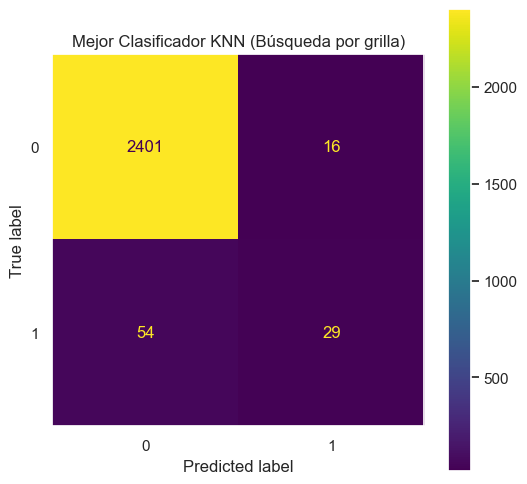

In [6]:
#Evaluamos
y_pred  = best_knn_grid.predict(X_test)

cm_best_knn_grid = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_grid,
                              display_labels=best_knn_grid.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda por grilla)");

In [7]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Búsqueda por grilla)")
P = np.sum(cm_best_knn_grid[1, :])
N = np.sum(cm_best_knn_grid[0, :])
TP = cm_best_knn_grid[1, 1]
TN = cm_best_knn_grid[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Búsqueda por grilla)
Sensibilidad: 0.3493975903614458
Especificidad: 0.9933802234174597
Exactitud balanceada: 0.6713889068894527
Precision: 0.6444444444444445
Recuperación: 0.3493975903614458
F1-score: 0.453125


Por otro lado, la búsqueda aleatoria selecciona aleatoriamente combinaciones de hiperparámetros para evaluar el rendimiento del modelo. Aunque esta estrategia es menos 
costosa computacionalmente que la búsqueda de grilla, puede ser menos efectiva para explorar el espacio de hiper-parámetros de manera sistemática.

Usemos la búsqueda aleatoria que nos ofrece [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) y aprovechemos que buscamos menos a ampliar la grilla de hiper-parámetros:

In [8]:
from sklearn.model_selection import RandomizedSearchCV

classifier_knn = KNeighborsClassifier()

hyperparams = {"n_neighbors": np.arange(1, 100),        
               "weights": ["uniform", "distance"],  
               "p": np.arange(1.0, 100.0)}              

# Creamos un método de busqueda por grilla:
grid_random = RandomizedSearchCV(classifier_knn,
                                 hyperparams,
                                 n_iter=1800, # Es el mismo número de iteraciones que el anterior pero la grilla es más grande.
                                 refit=False,
                                 cv=3,
                                 scoring='f1',
                                 n_jobs=-1)

grid_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=1800,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8...
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91.,
       92., 93., 94., 95., 96., 97., 98., 99.]),
                                        'weights': ['uniform', 'distance']},
                   refit=False, scoring='f1')

Veamos los mejores parámetros encontrados:

In [9]:
grid_random.best_params_

{'weights': 'distance', 'p': 95.0, 'n_neighbors': 10}

El resultado que encuentre aqui puede ser muy diferente cada vez que se ejecuta. Veamos el mejor modelo, que resultado nos da:

In [10]:
best_knn_grid_random = KNeighborsClassifier(**grid_random.best_params_)
best_knn_grid_random.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=95.0, weights='distance')

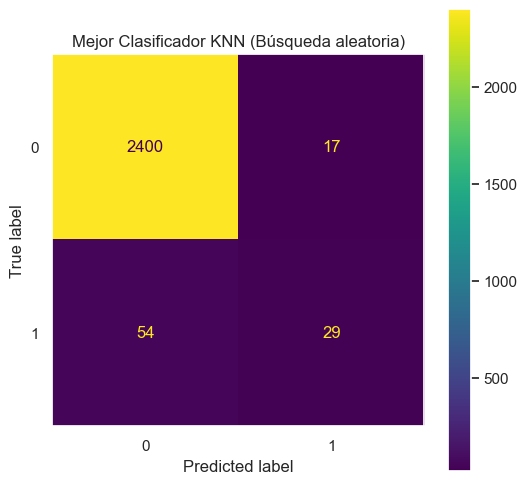

In [11]:
#Evaluamos
y_pred  = best_knn_grid_random.predict(X_test)

cm_best_knn_grid_random = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_grid_random,
                              display_labels=best_knn_grid_random.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Búsqueda aleatoria)");

In [12]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Búsqueda aleatoria)")
P = np.sum(cm_best_knn_grid_random[1, :])
N = np.sum(cm_best_knn_grid_random[0, :])
TP = cm_best_knn_grid_random[1, 1]
TN = cm_best_knn_grid_random[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especificidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Búsqueda aleatoria)
Sensibilidad: 0.3493975903614458
Especificidad: 0.9929664873810509
Exactitud balanceada: 0.6711820388712484
Precision: 0.6304347826086957
Recuperación: 0.3493975903614458
F1-score: 0.4496124031007752


Ambos enfoques tienen sus ventajas y desventajas, y la elección entre ellos dependerá del tamaño del espacio de hiperparámetros, los recursos computacionales disponibles y la naturaleza del problema de machine learning que se está abordando.